In [204]:
import torch
import os
import ot
import time
import random
import numpy as np
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from scipy.sparse.csc import csc_matrix
from scipy.sparse.csr import csr_matrix
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from sklearn.neighbors import NearestNeighbors
from torch.backends import cudnn
import scipy.sparse as sp
import pandas as pd
    
global ret_global
global ret_a_global
global label_global


class GraphST():
    def __init__(self, 
        adata,
        adata_sc = None,
        device= torch.device('cpu'),
        learning_rate=0.001,
        learning_rate_sc = 0.01,
        weight_decay=0.00,
        epochs=600, 
        dim_input=3000,
        dim_output=64,
        random_seed = 41,
        alpha = 10,
        beta = 1,
        theta = 0.1,
        lamda1 = 10,
        lamda2 = 1,
        deconvolution = False,
        datatype = '10X'
        ):
        '''\

        Parameters
        ----------
        adata : anndata
            AnnData object of spatial data.
        adata_sc : anndata, optional
            AnnData object of scRNA-seq data. adata_sc is needed for deconvolution. The default is None.
        device : string, optional
            Using GPU or CPU? The default is 'cpu'.
        learning_rate : float, optional
            Learning rate for ST representation learning. The default is 0.001.
        learning_rate_sc : float, optional
            Learning rate for scRNA representation learning. The default is 0.01.
        weight_decay : float, optional
            Weight factor to control the influence of weight parameters. The default is 0.00.
        epochs : int, optional
            Epoch for model training. The default is 600.
        dim_input : int, optional
            Dimension of input feature. The default is 3000.
        dim_output : int, optional
            Dimension of output representation. The default is 64.
        random_seed : int, optional
            Random seed to fix model initialization. The default is 41.
        alpha : float, optional
            Weight factor to control the influence of reconstruction loss in representation learning. 
            The default is 10.
        beta : float, optional
            Weight factor to control the influence of contrastive loss in representation learning. 
            The default is 1.
        lamda1 : float, optional
            Weight factor to control the influence of reconstruction loss in mapping matrix learning. 
            The default is 10.
        lamda2 : float, optional
            Weight factor to control the influence of contrastive loss in mapping matrix learning. 
            The default is 1.
        deconvolution : bool, optional
            Deconvolution task? The default is False.
        datatype : string, optional    
            Data type of input. Our model supports 10X Visium ('10X'), Stereo-seq ('Stereo'), and Slide-seq/Slide-seqV2 ('Slide') data. 
        Returns
        -------
        The learned representation 'self.emb_rec'.

        '''
        self.adata = adata.copy()
        self.device = device
        self.learning_rate=learning_rate
        self.learning_rate_sc = learning_rate_sc
        self.weight_decay=weight_decay
        self.epochs=epochs
        self.random_seed = random_seed
        self.alpha = alpha
        self.beta = beta
        self.theta = theta
        self.lamda1 = lamda1
        self.lamda2 = lamda2
        self.deconvolution = deconvolution
        self.datatype = datatype
        
        fix_seed(self.random_seed)
        
        if 'highly_variable' not in adata.var.keys():
           preprocess(self.adata)
        
        if 'adj' not in adata.obsm.keys():
           if self.datatype in ['Stereo', 'Slide']:
              construct_interaction_KNN(self.adata)
           else:    
              construct_interaction(self.adata)
         
        if 'label_CSL' not in adata.obsm.keys():    
           add_contrastive_label(self.adata)
           
        if 'feat' not in adata.obsm.keys():
           get_feature(self.adata)
        
        self.features = torch.FloatTensor(self.adata.obsm['feat'].copy()).to(self.device)
        self.features_a = torch.FloatTensor(self.adata.obsm['feat_a'].copy()).to(self.device)
        self.label_CSL = torch.FloatTensor(self.adata.obsm['label_CSL']).to(self.device)
        self.adj = self.adata.obsm['adj']
        self.graph_neigh = torch.FloatTensor(self.adata.obsm['graph_neigh'].copy() + np.eye(self.adj.shape[0])).to(self.device)
    
        self.dim_input = self.features.shape[1]
        self.dim_output = dim_output
        
        if self.datatype in ['Stereo', 'Slide']:
           #using sparse
           print('Building sparse matrix ...')
           self.adj = preprocess_adj_sparse(self.adj).to(self.device)
        else: 
           # standard version
           self.adj = preprocess_adj(self.adj)
           self.adj = torch.FloatTensor(self.adj).to(self.device)
        
        if self.deconvolution:
           self.adata_sc = adata_sc.copy() 
            
           if isinstance(self.adata.X, csc_matrix) or isinstance(self.adata.X, csr_matrix):
              self.feat_sp = adata.X.toarray()[:, ]
           else:
              self.feat_sp = adata.X[:, ]
           if isinstance(self.adata_sc.X, csc_matrix) or isinstance(self.adata_sc.X, csr_matrix):
              self.feat_sc = self.adata_sc.X.toarray()[:, ]
           else:
              self.feat_sc = self.adata_sc.X[:, ]
            
           # fill nan as 0
           self.feat_sc = pd.DataFrame(self.feat_sc).fillna(0).values
           self.feat_sp = pd.DataFrame(self.feat_sp).fillna(0).values
          
           self.feat_sc = torch.FloatTensor(self.feat_sc).to(self.device)
           self.feat_sp = torch.FloatTensor(self.feat_sp).to(self.device)
        
           if self.adata_sc is not None:
              self.dim_input = self.feat_sc.shape[1] 

           self.n_cell = adata_sc.n_obs
           self.n_spot = adata.n_obs
            
    def train(self):
        if self.datatype in ['Stereo', 'Slide']:
           self.model = Encoder_sparse(self.dim_input, self.dim_output, self.graph_neigh).to(self.device)
        else:
           self.model = Encoder(self.dim_input, self.dim_output, self.graph_neigh).to(self.device)
        self.loss_CSL = nn.BCEWithLogitsLoss()
    
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.learning_rate, 
                                          weight_decay=self.weight_decay)
        
        print('Begin to train ST data...')
        self.model.train()
        
        for epoch in tqdm(range(self.epochs)): 
            self.model.train()
              
            self.features_a = permutation(self.features)
            self.hiden_feat, self.emb, ret, ret_a, self.g = self.model(self.features, self.features_a, self.adj)
        
            self.loss_sl_1 = self.loss_CSL(ret, self.label_CSL)
            self.loss_sl_2 = self.loss_CSL(ret_a, self.label_CSL)
            self.loss_feat = F.mse_loss(self.features, self.emb)

            self.ret = ret
            self.ret_a = ret_a

            raise ValueError
                                    
            loss =  self.alpha*self.loss_feat + self.beta*(self.loss_sl_1 + self.loss_sl_2)
            
            self.optimizer.zero_grad()
            loss.backward() 
            self.optimizer.step()
        
        print("Optimization finished for ST data!")
        
        with torch.no_grad():
             self.model.eval()
             if self.deconvolution:
                self.emb_rec = self.model(self.features, self.features_a, self.adj)[1]
                
                return self.emb_rec
             else:  
                if self.datatype in ['Stereo', 'Slide']:
                   self.emb_rec = self.model(self.features, self.features_a, self.adj)[1]
                   self.emb_rec = F.normalize(self.emb_rec, p=2, dim=1).detach().cpu().numpy() 
                else:
                   self.emb_rec = self.model(self.features, self.features_a, self.adj)[1].detach().cpu().numpy()
                self.adata.obsm['emb'] = self.emb_rec
                
                return self.adata

class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = c.expand_as(h_pl)  

        sc_1 = self.f_k(h_pl, c_x)
        sc_2 = self.f_k(h_mi, c_x)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits
    
class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1)
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return F.normalize(global_emb, p=2, dim=1) 
    
class Encoder(Module):
    def __init__(self, in_features, out_features, graph_neigh, dropout=0.0, act=F.relu):
        super(Encoder, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.graph_neigh = graph_neigh
        self.dropout = dropout
        self.act = act
        
        self.weight1 = Parameter(torch.FloatTensor(self.in_features, self.out_features))
        self.weight2 = Parameter(torch.FloatTensor(self.out_features, self.in_features))
        self.reset_parameters()
        
        self.disc = Discriminator(self.out_features)

        self.sigm = nn.Sigmoid()
        self.read = AvgReadout()
        
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight1)
        torch.nn.init.xavier_uniform_(self.weight2)

    def forward(self, feat, feat_a, adj):
        z = F.dropout(feat, self.dropout, self.training)
        z = torch.mm(z, self.weight1)
        z = torch.mm(adj, z)
        
        hiden_emb = z
        
        h = torch.mm(z, self.weight2)
        h = torch.mm(adj, h)
        
        emb = self.act(z)
        
        z_a = F.dropout(feat_a, self.dropout, self.training)
        z_a = torch.mm(z_a, self.weight1)
        z_a = torch.mm(adj, z_a)
        emb_a = self.act(z_a)
        
        g = self.read(emb, self.graph_neigh) 
        g = self.sigm(g) 

        g_a = self.read(emb_a, self.graph_neigh)
        g_a = self.sigm(g_a) 

        print(g, g.shape)
        print(g_a, g_a.shape)
        
        ret = self.disc(g, emb, emb_a)  
        ret_a = self.disc(g_a, emb_a, emb) 
        
        return hiden_emb, h, ret, ret_a, g

def filter_with_overlap_gene(adata, adata_sc):
    # remove all-zero-valued genes
    #sc.pp.filter_genes(adata, min_cells=1)
    #sc.pp.filter_genes(adata_sc, min_cells=1)
    
    if 'highly_variable' not in adata.var.keys():
       raise ValueError("'highly_variable' are not existed in adata!")
    else:    
       adata = adata[:, adata.var['highly_variable']]
       
    if 'highly_variable' not in adata_sc.var.keys():
       raise ValueError("'highly_variable' are not existed in adata_sc!")
    else:    
       adata_sc = adata_sc[:, adata_sc.var['highly_variable']]   

    # Refine `marker_genes` so that they are shared by both adatas
    genes = list(set(adata.var.index) & set(adata_sc.var.index))
    genes.sort()
    print('Number of overlap genes:', len(genes))

    adata.uns["overlap_genes"] = genes
    adata_sc.uns["overlap_genes"] = genes
    
    adata = adata[:, genes]
    adata_sc = adata_sc[:, genes]
    
    return adata, adata_sc

def permutation(feature):
    # fix_seed(FLAGS.random_seed) 
    ids = np.arange(feature.shape[0])
    ids = np.random.permutation(ids)
    feature_permutated = feature[ids]
    
    return feature_permutated 

def construct_interaction(adata, n_neighbors=3):
    """Constructing spot-to-spot interactive graph"""
    position = adata.obsm['spatial']
    
    # calculate distance matrix
    distance_matrix = ot.dist(position, position, metric='euclidean')
    n_spot = distance_matrix.shape[0]
    
    adata.obsm['distance_matrix'] = distance_matrix
    
    # find k-nearest neighbors
    interaction = np.zeros([n_spot, n_spot])  
    for i in range(n_spot):
        vec = distance_matrix[i, :]
        distance = vec.argsort()
        for t in range(1, n_neighbors + 1):
            y = distance[t]
            interaction[i, y] = 1
         
    adata.obsm['graph_neigh'] = interaction
    
    #transform adj to symmetrical adj
    adj = interaction
    adj = adj + adj.T
    adj = np.where(adj>1, 1, adj)
    
    adata.obsm['adj'] = adj
    
def construct_interaction_KNN(adata, n_neighbors=3):
    position = adata.obsm['spatial']
    n_spot = position.shape[0]
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(position)  
    _ , indices = nbrs.kneighbors(position)
    x = indices[:, 0].repeat(n_neighbors)
    y = indices[:, 1:].flatten()
    interaction = np.zeros([n_spot, n_spot])
    interaction[x, y] = 1
    
    adata.obsm['graph_neigh'] = interaction
    
    #transform adj to symmetrical adj
    adj = interaction
    adj = adj + adj.T
    adj = np.where(adj>1, 1, adj)
    
    adata.obsm['adj'] = adj
    print('Graph constructed!')   

def preprocess(adata):
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, zero_center=False, max_value=10)
    
def get_feature(adata, deconvolution=False):
    if deconvolution:
       adata_Vars = adata
    else:   
       adata_Vars =  adata[:, adata.var['highly_variable']]
       
    if isinstance(adata_Vars.X, csc_matrix) or isinstance(adata_Vars.X, csr_matrix):
       feat = adata_Vars.X.toarray()[:, ]
    else:
       feat = adata_Vars.X[:, ] 
    
    # data augmentation
    feat_a = permutation(feat)
    
    adata.obsm['feat'] = feat
    adata.obsm['feat_a'] = feat_a    
    
def add_contrastive_label(adata):
    # contrastive label
    n_spot = adata.n_obs
    one_matrix = np.ones([n_spot, 1])
    zero_matrix = np.zeros([n_spot, 1])
    label_CSL = np.concatenate([one_matrix, zero_matrix], axis=1)
    adata.obsm['label_CSL'] = label_CSL
    
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
    return adj.toarray()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj)+np.eye(adj.shape[0])
    return adj_normalized 

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_adj_sparse(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_mx_to_torch_sparse_tensor(adj_normalized)    

def fix_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 

/tmp/ipykernel_643296/454896261.py:10: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_643296/454896261.py:11: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


In [190]:
import scanpy as sc
import matplotlib.pyplot as plt

datadir = '/data1/shahs3/users/mezallj1/data/dlpfc'#dataset path

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] ='/home/mezallj1/miniconda3/envs/graphst/lib/R'

In [191]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [192]:
# the number of clusters
n_clusters = 7

In [193]:
adata.var_names_make_unique()

In [194]:
# define and train model
model = GraphST(adata)
adata = model.train()

Begin to train ST data...


  0%|          | 0/600 [00:00<?, ?it/s]

tensor([[0.5252, 0.5000, 0.5006,  ..., 0.5000, 0.5615, 0.5000],
        [0.5016, 0.5054, 0.5047,  ..., 0.5195, 0.5000, 0.5000],
        [0.5150, 0.5000, 0.5210,  ..., 0.5150, 0.5436, 0.5008],
        ...,
        [0.5179, 0.5000, 0.5000,  ..., 0.5022, 0.5411, 0.5000],
        [0.5093, 0.5000, 0.5074,  ..., 0.5199, 0.5472, 0.5000],
        [0.5089, 0.5000, 0.5000,  ..., 0.5022, 0.5656, 0.5000]],
       grad_fn=<SigmoidBackward0>) torch.Size([3639, 64])
tensor([[0.5016, 0.5000, 0.5000,  ..., 0.5306, 0.5500, 0.5000],
        [0.5148, 0.5000, 0.5000,  ..., 0.5242, 0.5318, 0.5000],
        [0.5294, 0.5000, 0.5012,  ..., 0.5000, 0.5210, 0.5000],
        ...,
        [0.5112, 0.5000, 0.5019,  ..., 0.5085, 0.5348, 0.5000],
        [0.5284, 0.5000, 0.5058,  ..., 0.5017, 0.5546, 0.5000],
        [0.5219, 0.5000, 0.5212,  ..., 0.5148, 0.5998, 0.5000]],
       grad_fn=<SigmoidBackward0>) torch.Size([3639, 64])


ValueError: 

(array([[  11.,   80.,  347.,  928., 1169.,  740.,  291.,   60.,   10.,
            3.],
        [   9.,   55.,  393.,  914., 1172.,  765.,  261.,   60.,   10.,
            0.]]),
 array([-2.12799454, -1.66143131, -1.19486809, -0.72830486, -0.26174164,
         0.20482159,  0.67138481,  1.13794804,  1.60451126,  2.07107449,
         2.53763771]),
 <a list of 2 BarContainer objects>)

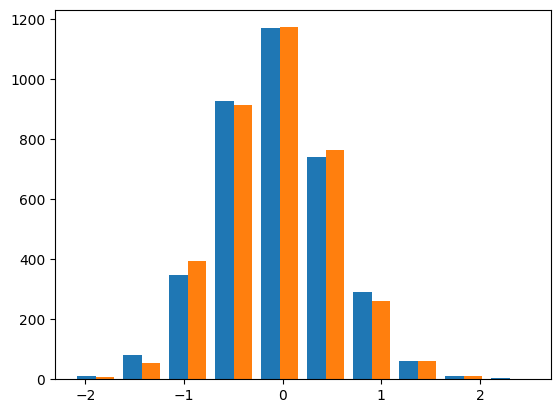

In [195]:
plt.hist(model.ret.detach().cpu().numpy())

(array([[2.055e+03, 9.700e+02, 3.820e+02, 1.680e+02, 5.500e+01, 4.000e+00,
         5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.637e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [2.973e+03, 5.190e+02, 1.230e+02, 2.200e+01, 2.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.449e+03, 1.540e+02, 2.700e+01, 9.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [5.810e+02, 9.650e+02, 9.940e+02, 7.530e+02, 2.630e+02, 6.500e+01,
         1.800e+01, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.397e+03, 1.197e+03, 7.410e+02, 2.470e+02, 4.900e+01, 8.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [2.620e+02, 7.480e+02, 1.137e+03, 9.420e+02, 4.190e+02, 1.120e+02,
         1.700e+01, 2.000e+00, 0.000e+00, 0.000e+00],
        [3.475e+03, 1.430e+02, 1.600e+01, 5.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.

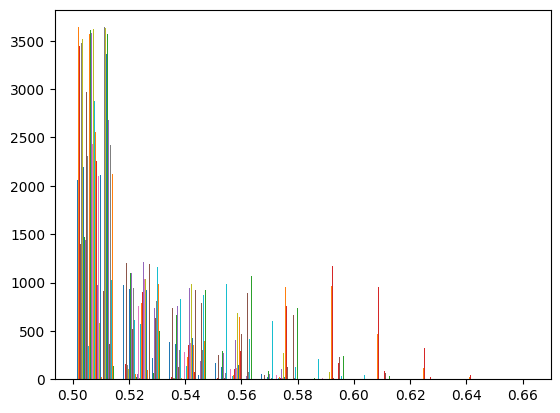

In [198]:
plt.hist(model.g.detach().cpu().numpy())

In [202]:
print(model.ret, model.label_CSL, model.ret.shape, model.label_CSL.shape, model.ret.device, model.label_CSL.device, model.ret.dtype, model.label_CSL.dtype)

tensor([[ 0.5604,  0.0381],
        [-0.4620, -0.1766],
        [ 0.8396,  0.3410],
        ...,
        [ 0.7322,  0.3061],
        [ 0.4570, -1.0281],
        [ 0.2451, -0.4176]], grad_fn=<CatBackward0>) tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]) torch.Size([3639, 2]) torch.Size([3639, 2]) cpu cpu torch.float32 torch.float32


In [197]:
np.sum(model.ret.detach().cpu().numpy() == 0)

0

In [ ]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

In [ ]:
# clustering
from GraphST.utils import clustering
clustering(adata, n_clusters, radius=radius, refinement=False) #For DLPFC dataset, we use optional refinement step.

In [8]:
obs_df = adata.obs.dropna()

In [9]:
ari = metrics.adjusted_rand_score(obs_df['domain'], obs_df['Region'])
print(ari)

0.6342579253141447


In [ ]:
print(ari)

In [208]:
model.loss_CSL(torch.tensor([5.,10.]),torch.tensor([1.,0.]))

tensor(5.0034)

In [220]:
torch.tensor([1.,0.]).dtype

torch.float32

In [217]:
nn.BCEWithLogitsLoss(torch.tensor([5.,10.]),torch.tensor([1.,0.]))

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [219]:
nn.BCEWithLogitsLoss.__file__

AttributeError: type object 'BCEWithLogitsLoss' has no attribute '__file__'

In [211]:
model.loss_CSL?

Signature:      model.loss_CSL(*args, **kwargs)
Type:           BCEWithLogitsLoss
String form:    BCEWithLogitsLoss()
File:           ~/miniconda3/envs/graphst/lib/python3.8/site-packages/torch/nn/modules/loss.py
Docstring:     
This loss combines a `Sigmoid` layer and the `BCELoss` in one single
class. This version is more numerically stable than using a plain `Sigmoid`
followed by a `BCELoss` as, by combining the operations into one layer,
we take advantage of the log-sum-exp trick for numerical stability.

The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:

.. math::
    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = - w_n \left[ y_n \cdot \log \sigma(x_n)
    + (1 - y_n) \cdot \log (1 - \sigma(x_n)) \right],

where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
(default ``'mean'``), then

.. math::
    \ell(x, y) = \begin{cases}
        \operatorname{mean}(L), & \text{if reduction} = \text{`mean';}\\
        \opera